# HHL Algorithm Sandbox

# HHL Implementation for 3x3 Matrix

The structure of this notebook is as follows:
1. Define the functions necessary to implement HHL for a 3x3 invertible, non-hermitian matrix.
2. Setup a testing suite using those functions for easy fine-tuning of parameters and exploration of the code.

## Defining Functions 


First, import the necessary packages.

In [105]:
import numpy as np
from numpy import pi
import scipy
from qiskit.extensions import UnitaryGate
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, execute, Aer
from qiskit.visualization import plot_histogram



## Defining the 3x3 Matrix

We need to define a $3\times3$ invertible but non-hermitian A in Qiskit. That is, the following two qualities must hold:
$$AA^{-1} = A^{-1}A = I_n$$
$$A \neq A^{\dag}$$
If we restric ourselves to only real values, the matrix we can choose must then follow the two qualities: invertible and $A\neq A^T$.

One such matrix is the following:

$$A = \Bigg(\begin{matrix}
    1 & 1 & 0 \\
    -1 & 1 & -1 \\
    0 & 0.13 & 1.3 
\end{matrix}\Bigg)$$


In [106]:
# A = np.matrix([[1, 0, 0], [0, 1, -1], [0, 1, 1]]) # gets 1.4 but only 2 eigenvalues
A = np.matrix([[1, 1, 0], [-1, 1, -1], [0, .13, 1.3]]) # gets 1.9 and 3 distinct evals


def hermitian_and_pad_matrix(A):
    # define a 3x3 zero matrix for aid in construction
    zero = np.matrix([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    # construct A' to be a hermitian matrix
    Ap = np.vstack((np.hstack((zero, A)), np.hstack((A.getH(), zero))))

    A_p = np.pad(Ap, ((0, 2), (0, 2)))

    # pad 
    A_p[-1][-1], A_p[-2][-2] = 1, 1

    eig_val, eig_vec = scipy.linalg.eig(A_p)

    A_p /= max(np.real(eig_val)) # rescale matrix so that eigenvalues are between -1 and 1

    return A_p

A_p = hermitian_and_pad_matrix(A)

eig_val, eig_vec = scipy.linalg.eig(A_p)

kappa = np.linalg.cond(A_p)
print(f"Kappa = {kappa}")

print("-"*30)
print(f"Eigen Values:")
for e_val in eig_val:
    print(e_val)


Kappa = 1.9216644857061567
------------------------------
Eigen Values:
(-1.0000000000000004+0j)
(-0.7377735838000788+0j)
(-0.5214430145579317+0j)
(1.0000000000000007+0j)
(0.5214430145579312+0j)
(0.7377735838000787+0j)
(0.5203822037812854+0j)
(0.5203822037812854+0j)


In [107]:
A

matrix([[ 1.  ,  1.  ,  0.  ],
        [-1.  ,  1.  , -1.  ],
        [ 0.  ,  0.13,  1.3 ]])

Before I can use the HHL algorithm, we need to convert the non-hermitian matrix into a hermitian matrix form. We can complete this by performing the operation defined in the article. That is, define:
$$A' = \Bigg(\begin{matrix}
    0 & A \\
    A^{\dag} & 0 \end{matrix}\Bigg)$$
A' is now hermitian and can be used to solve  $A'\cdot y = \Bigg[\begin{matrix} b  \\ 0 \end{matrix}\Bigg]$; where $y = \Bigg[\begin{matrix} 0  \\ x \end{matrix}\Bigg]$

HHL requires that the matrix $A$ is a $2^n\times 2^n$ matrix. Our $A'$ is currently $6\times6$, so we need to pad it to extend it to $8\times8$. Our padding constraints need to maintain invertibility and hermitian-ness. To accomplish this, we pad the matrix to have 1's along the diagonal of the 2 added dimensions. For consistency, let's continue to call this matrix $A'$. We perform this logic in the helper function `hermitian_and_pad_matrix()`.

Let's inspect the eigenvalues of this matrix.

In [108]:
eig_val, eig_vec = scipy.linalg.eig(A_p)

print("-"*30)
print(f"Eigen Values:")
for e_val in eig_val:
    print(e_val)
print("-"*30)
print(f"Eigen Vectors:")
print(eig_vec)


------------------------------
Eigen Values:
(-1.0000000000000004+0j)
(-0.7377735838000788+0j)
(-0.5214430145579317+0j)
(1.0000000000000007+0j)
(0.5214430145579312+0j)
(0.7377735838000787+0j)
(0.5203822037812854+0j)
(0.5203822037812854+0j)
------------------------------
Eigen Vectors:
[[ 0.02764673 -0.7021214  -0.07912776 -0.02764673  0.07912776 -0.7021214
   0.          0.        ]
 [-0.60797563 -0.06398656  0.35534681  0.60797563 -0.35534681 -0.06398656
   0.          0.        ]
 [ 0.3600018  -0.05414114  0.60619093 -0.3600018  -0.60619093 -0.05414114
   0.          0.        ]
 [-0.33076656  0.45010287  0.43359069 -0.33076656  0.43359069 -0.45010287
   0.          0.        ]
 [ 0.27763882  0.54533205 -0.35430163  0.27763882 -0.35430163 -0.54533205
   0.          0.        ]
 [-0.55991979  0.00451201 -0.43182112 -0.55991979 -0.43182112 -0.00451201
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.        ]
 [ 0.          0

Similarly, we initialize and pad the $b$ solution vector. 

In [109]:
# initialize the b solution vector
b = np.array([1, 3, 2])

# pad the b array with 0's to be 8 by 1

def pad_b(b):
    return np.append(b, [0, 0, 0, 0, 0])

b_p = pad_b(b)


In [110]:
print(A_p.shape)
print(b_p.shape)

(8, 8)
(8,)


## Implementing the HHL algorithm

### Defining parameters

Some parameters should be chosen based on the conditional number of the matrix A. That is, C, used in conditional rotation should be on the order of $1/\kappa$ where $\kappa$ is the conditional number of the matrix A. If $\kappa$ is too large, some of the rows of A will be very linearly dependent and thus the inverse of A is very unstable.

In [111]:
kappa = np.linalg.cond(A_p)
print(f"Kappa = {kappa}")

Kappa = 1.9216644857061567


We have 3 parameters for HHL. 
- $T$ is used during the exponentiation of the matrix $A'$ ($e^{i\cdot A'\cdot T}$). $T$ needs to be relatively large so that the Fourier transofrm of the conditional Hamiltonian evolution of $A'$ (Eq 3 in the reference paper) has an $\alpha$ that acts as a sync function. 
- $C$ is used during conditional rotation. $C$ needs to be on the order of $1/\kappa$ where $\kappa$ is the conditional number of $A'$ as described previously.
- $n_{eig}$ is used during QPE and defines the number of qubits used to estimate the eigenvalues of $A'$ up to $n_{eig}$ bits of precision.

In [112]:
T = 150 # Used in hamiltonian evolution. Needs to be relatively large so that alpha in Eq (3) approximates as sync functions
# C = 1/2 # Used in conditional rotation. Needs to be on the order of 1/kappa where kappa is the conditional number of A
n_eig = 8 # Used in QPE, number of qubits to estimate the eigenvalues of A, defines the precision of the eigenvalues up to n_eig bits

n = 3 # 2**n x 2**n A. This defines the number of qubits needed for the dimensions of this problem. Specifically 8 dimensions can be encoded with 3 qubits. 


### Loading The Data

In [113]:
def construct_registers(n_eig, n, b_p):
    aux = QuantumRegister(1, 'aux') # for conditional eigenvalue inversion

    n_l = QuantumRegister(n_eig, 'nl') # stores binary representation of the eigenvalues 
    n_b = QuantumRegister(n, 'nb') # contains the vector solution

    c = ClassicalRegister(n + n_eig + 1, 'c') # 3 for n_b, n_eig for n_l, and 1 for the auxiliary

    return aux, n_l, n_b, c

aux, n_l, n_b, c = construct_registers(n_eig, n, b_p)

def construct_init_circ(n_eig, n, b_p):
    # state preparation of b: |0> -> |b>
    init_circ = QuantumCircuit(aux, n_l, n_b, c)

    b_p = b_p/scipy.linalg.norm(b_p) # normalize b, so it is ready for loading.
    init_circ.initialize(b_p, n_b)

    return init_circ

init_circ = construct_init_circ(n_eig, n, b_p)



### Quantum Phase Estimation

We'll start by converting $A'$ to be a unitary operator by exponentiating it $e^{i\cdot A'\cdot T}$ and using Qiskit to convert to a unitary operator.

In [114]:
def convert_Ap_to_gate(A_p, T):
    # convert to unitary matrix through exponentiation
    U_mat = scipy.linalg.expm(1j*A_p*T)

    # convert to a unitary operator with Qiskit
    U = UnitaryGate(U_mat)
    U.name = "$U$"
    return U


U = convert_Ap_to_gate(A_p, T)

The following is the circuit implementation for QPE.

In [115]:
def construct_qpe_circ(U):
    qpe_circ = QuantumCircuit(aux, n_l, n_b, c)
    qpe_circ.barrier()

    # First, perform a hadamard on all the memory qubits.
    qpe_circ.h(n_l)

    # Apply powers of controlled U on the target qubits 
    for i in range(n_eig): 
        Upow = U.power(2**(n_eig-1-i)) 
        ctrl_Upow = Upow.control() 
        qpe_circ.append(ctrl_Upow, [n_l[i], n_b[0], n_b[1], n_b[2]]) 
    qpe_circ.barrier() 

    # Compute the inverse quantum fourier transform 
    for qubit in range(n_eig//2): 
        qpe_circ.swap(n_l[qubit], n_l[n_eig-qubit-1]) 
    for i in range(n_eig): 
        for m in range(i): 
            qpe_circ.cp(-pi/(2**(i-m)), n_l[n_eig-1-m], n_l[n_eig-1-i])
        qpe_circ.h(n_l[n_eig-1-i])
        qpe_circ.barrier()
    qpe_circ.barrier()
    return qpe_circ

qpe_circ = construct_qpe_circ(U)

#### Testing our QPE through repeated measurement.

To test our QPE implementation and inspect the estimated phase of the exponentiated matrix, we repeatedly measure the encoded qubits $n_l$.

In [116]:
def construct_qpe_measure_circ(init_circ, qpe_circ):
    measure_circ = init_circ.compose(qpe_circ)
    measure_circ.measure(n_l, c[:n_eig])

    return measure_circ

measure_circ = construct_qpe_measure_circ(init_circ, qpe_circ)

To test working condition, let's measure the $n_l$ qubits to see if the eigenvalues of A are being sufficiently encoded.

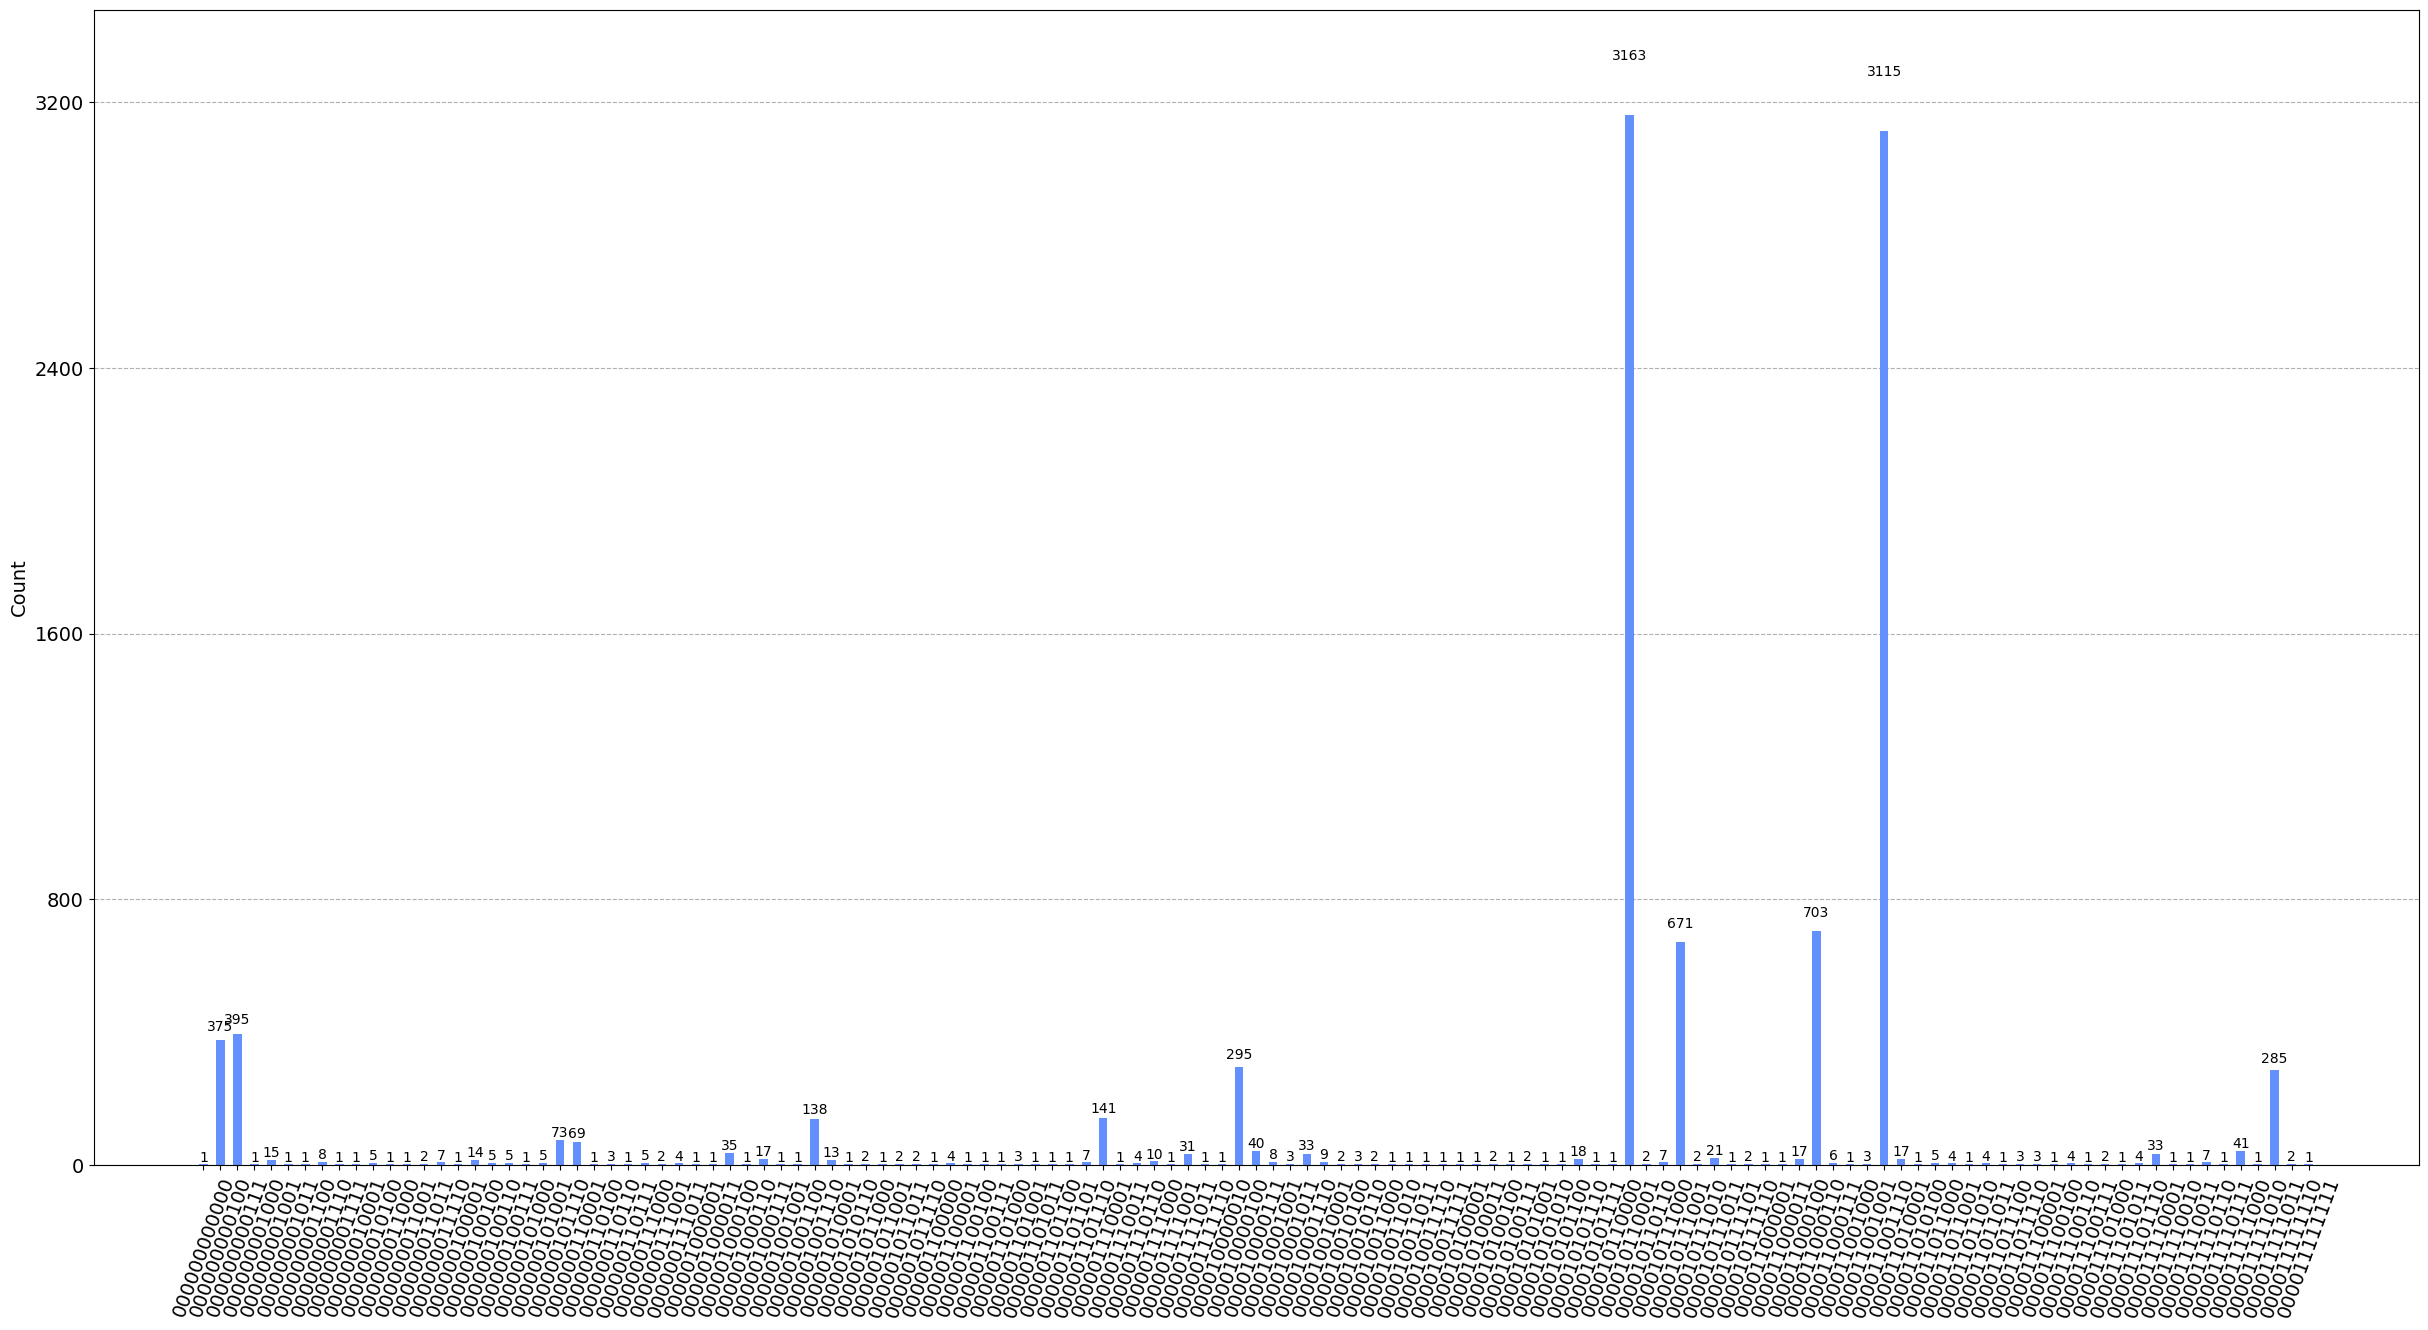

In [117]:
def evaluate_QPE(measure_circ):
    nShots = 10000

    backend_qasm = Aer.get_backend('qasm_simulator')
    # perform constant_full_circuit just 1 time and plot the histogram of states! 
    res = execute(measure_circ, backend_qasm,shots=nShots).result() 
    counts = res.get_counts(); 
    return counts

counts = evaluate_QPE(measure_circ)

plot_histogram(counts, figsize=(30, 15))

In [118]:
actual_b_j = scipy.linalg.solve(eig_vec, b_p)**2

# need to compare to estimated b_j, 
# 

print(actual_b_j)

[1.1583712  1.00473234 4.83689646 1.1583712  4.83689646 1.00473234
 0.         0.        ]


Evaluating the outputs of QPE to match the expected eigenvalues of the matrix.

In [119]:
# find six peaks that must correspond to the bitstring complements of each other. Verifying that QPE is working.

In [120]:
def calculate_lmd_dec(bit_str):
    lmd = 0
    for ind, i in enumerate(bit_str[::-1]):
        lmd += int(i)/2**(ind+1)

    return lmd

def binaryToDec(n):
    return int(n, 2)

# 10 classical register, only consider the top 6: i[0][4:]
def get_top_ev_bin(counts):
    return [i[0][-n_eig:] for i in sorted(counts.items(), key=lambda i: i[1], reverse=True)[:10]]

top_ev_bin = get_top_ev_bin(counts)
print(top_ev_bin)


def get_top_ev_dec(top_phase):
    return [binaryToDec(i[::-1]) for i in top_phase]


top_dec = get_top_ev_dec(top_ev_bin)
print(top_dec)


['10110001', '11001110', '11000110', '10111001', '00000111', '00000100', '10000100', '11111011', '01110001', '01001110']
[141, 115, 99, 157, 224, 32, 33, 223, 142, 114]


In [121]:

def get_real_ev(A_p):
    eig_val, eig_vec = scipy.linalg.eig(A_p)
    return np.real(eig_val)

real_ev = get_real_ev(A_p)

def get_real_ev_dec(real_ev):
    # in order to compare the real eigenvalues with the lambda from the histogram after QPE
    return [int(2**n_eig * T * val / (2*pi) % (2**n_eig)) for val in real_ev] 

real_ev_dec = get_real_ev_dec(real_ev)

print(f"Lambda associated with each eigenval: {real_ev_dec}")


Lambda associated with each eigenval: [32, 99, 141, 223, 114, 156, 108, 108]


Manual construction of which lambdas correspond to negative eigenvalues

In [122]:
def print_real_vs_exp_evals(top_dec, real_ev_dec, real_ev):
    print("-"*15+"compare this ev_dec array"+"-"*15)
    print(top_dec)
    print("-"*15+"to the following real_ev's"+"-"*15)
    [print(i[0], ":",  round(i[1], 3)) for i in zip(real_ev_dec, real_ev)]
    print("Use this to manually construct the `correspondance` array:")
    print("correspondance = [x_i] where x_i is 1 if the corresponding real"
        "ev to the i'th experimental ev_dec is pos, else -1")

    return

print_real_vs_exp_evals(top_dec, real_ev_dec, real_ev)


---------------compare this ev_dec array---------------
[141, 115, 99, 157, 224, 32, 33, 223, 142, 114]
---------------to the following real_ev's---------------
32 : -1.0
99 : -0.738
141 : -0.521
223 : 1.0
114 : 0.521
156 : 0.738
108 : 0.52
108 : 0.52
Use this to manually construct the `correspondance` array:
correspondance = [x_i] where x_i is 1 if the corresponding realev to the i'th experimental ev_dec is pos, else -1


In [123]:
# currently written for [32, 99, 141, 223, 114, 156, 108, 108]
correspondance = [-1, -1, -1, 1, 1, 1, 1, 1]

We can see in this comparison between the real eigenvalues and those that QPE output. For example, two such arrays could have that: $43=43$, $21=20 \text{ or } 19$, $44=44$, $20=20 \text{ or } 19$, $1=1$, $63=62$ with some slight approximation errors. In this way, we have verified that the QPE algorithm is successful.

### Eigenvalue inversion.



Using the eigenvalues output from QPE, we can construct a circuit that rotates conditionally based on these eigenvalues.

Because of arcsin in rotation the parameter $C$ must be smaller than the smallest eigenvalue. Let's calculate $C$ to be bounded by the minimum $\lambda$.


In [124]:
def calculate_min_C(correspondance, top_ev_bin):
    C = calculate_lmd_dec(top_ev_bin[0])
    for neg, ev in zip(correspondance, top_ev_bin):
        eigenvalue = calculate_lmd_dec(ev)
        # if the lambda corresponds to a negative eigenvalue, invert it
        if neg == -1:
            eigenvalue = -1*(1 - eigenvalue)
        lambda_j = eigenvalue * (2*pi/T)
        C = min(C, abs(lambda_j)-0.0001)
    return C


C = calculate_min_C(correspondance, top_ev_bin)
C

0.005135987755982988

The following is the circuit construction.

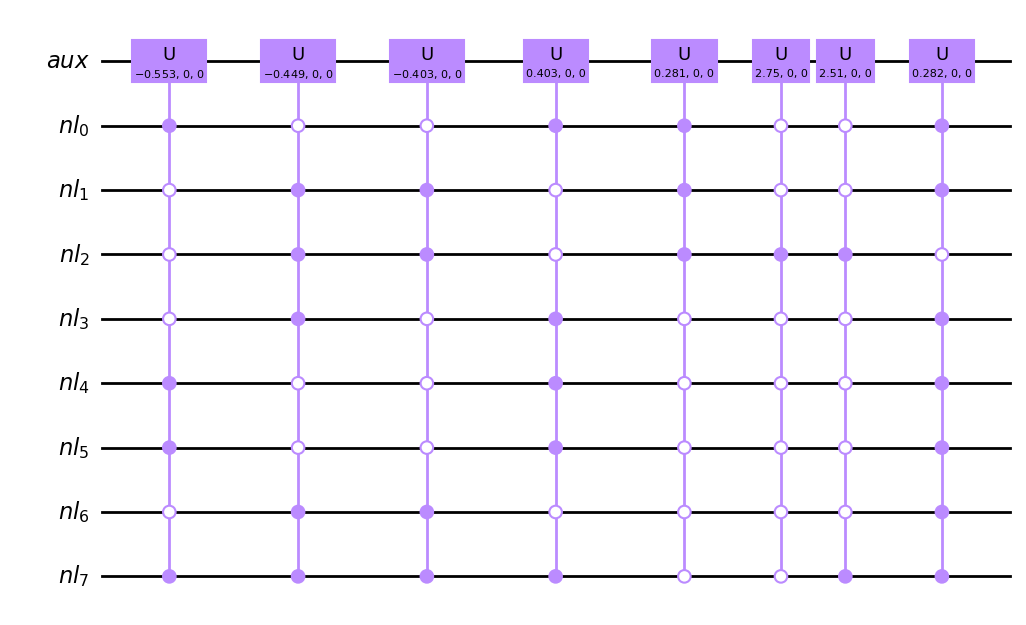

In [125]:
# circuit construction
from qiskit.circuit.library.standard_gates import UGate
import math

def theta_angle(C, eigenvalue_bin, neg):
    eigenvalue = calculate_lmd_dec(eigenvalue_bin)
    # if the lambda corresponds to a negative eigenvalue
    if neg == -1:
        eigenvalue = -1*(1 - eigenvalue)
    lambda_j = eigenvalue * (2*pi/T)

    ratio = C/lambda_j
    return math.asin(ratio)

def construct_eig_invert_circ(correspondance, eigenvalues_bin):
    C = calculate_min_C(correspondance, eigenvalues_bin)

    eig_invert_circ = QuantumCircuit(aux, n_l)

    for neg, ev_bin in zip(correspondance, eigenvalues_bin):
        rot_angle = theta_angle(C, ev_bin, neg)
        cu_gate = UGate(rot_angle*2, 0, 0).control(n_eig, ctrl_state = ev_bin)
        wiring = [i for i in range(1, n_eig+1)]+[0]
        eig_invert_circ.append(cu_gate, wiring)
    return eig_invert_circ


eig_invert_circ = construct_eig_invert_circ(correspondance, top_ev_bin)
eig_invert_circ.draw('mpl')

### Reverse QPE.

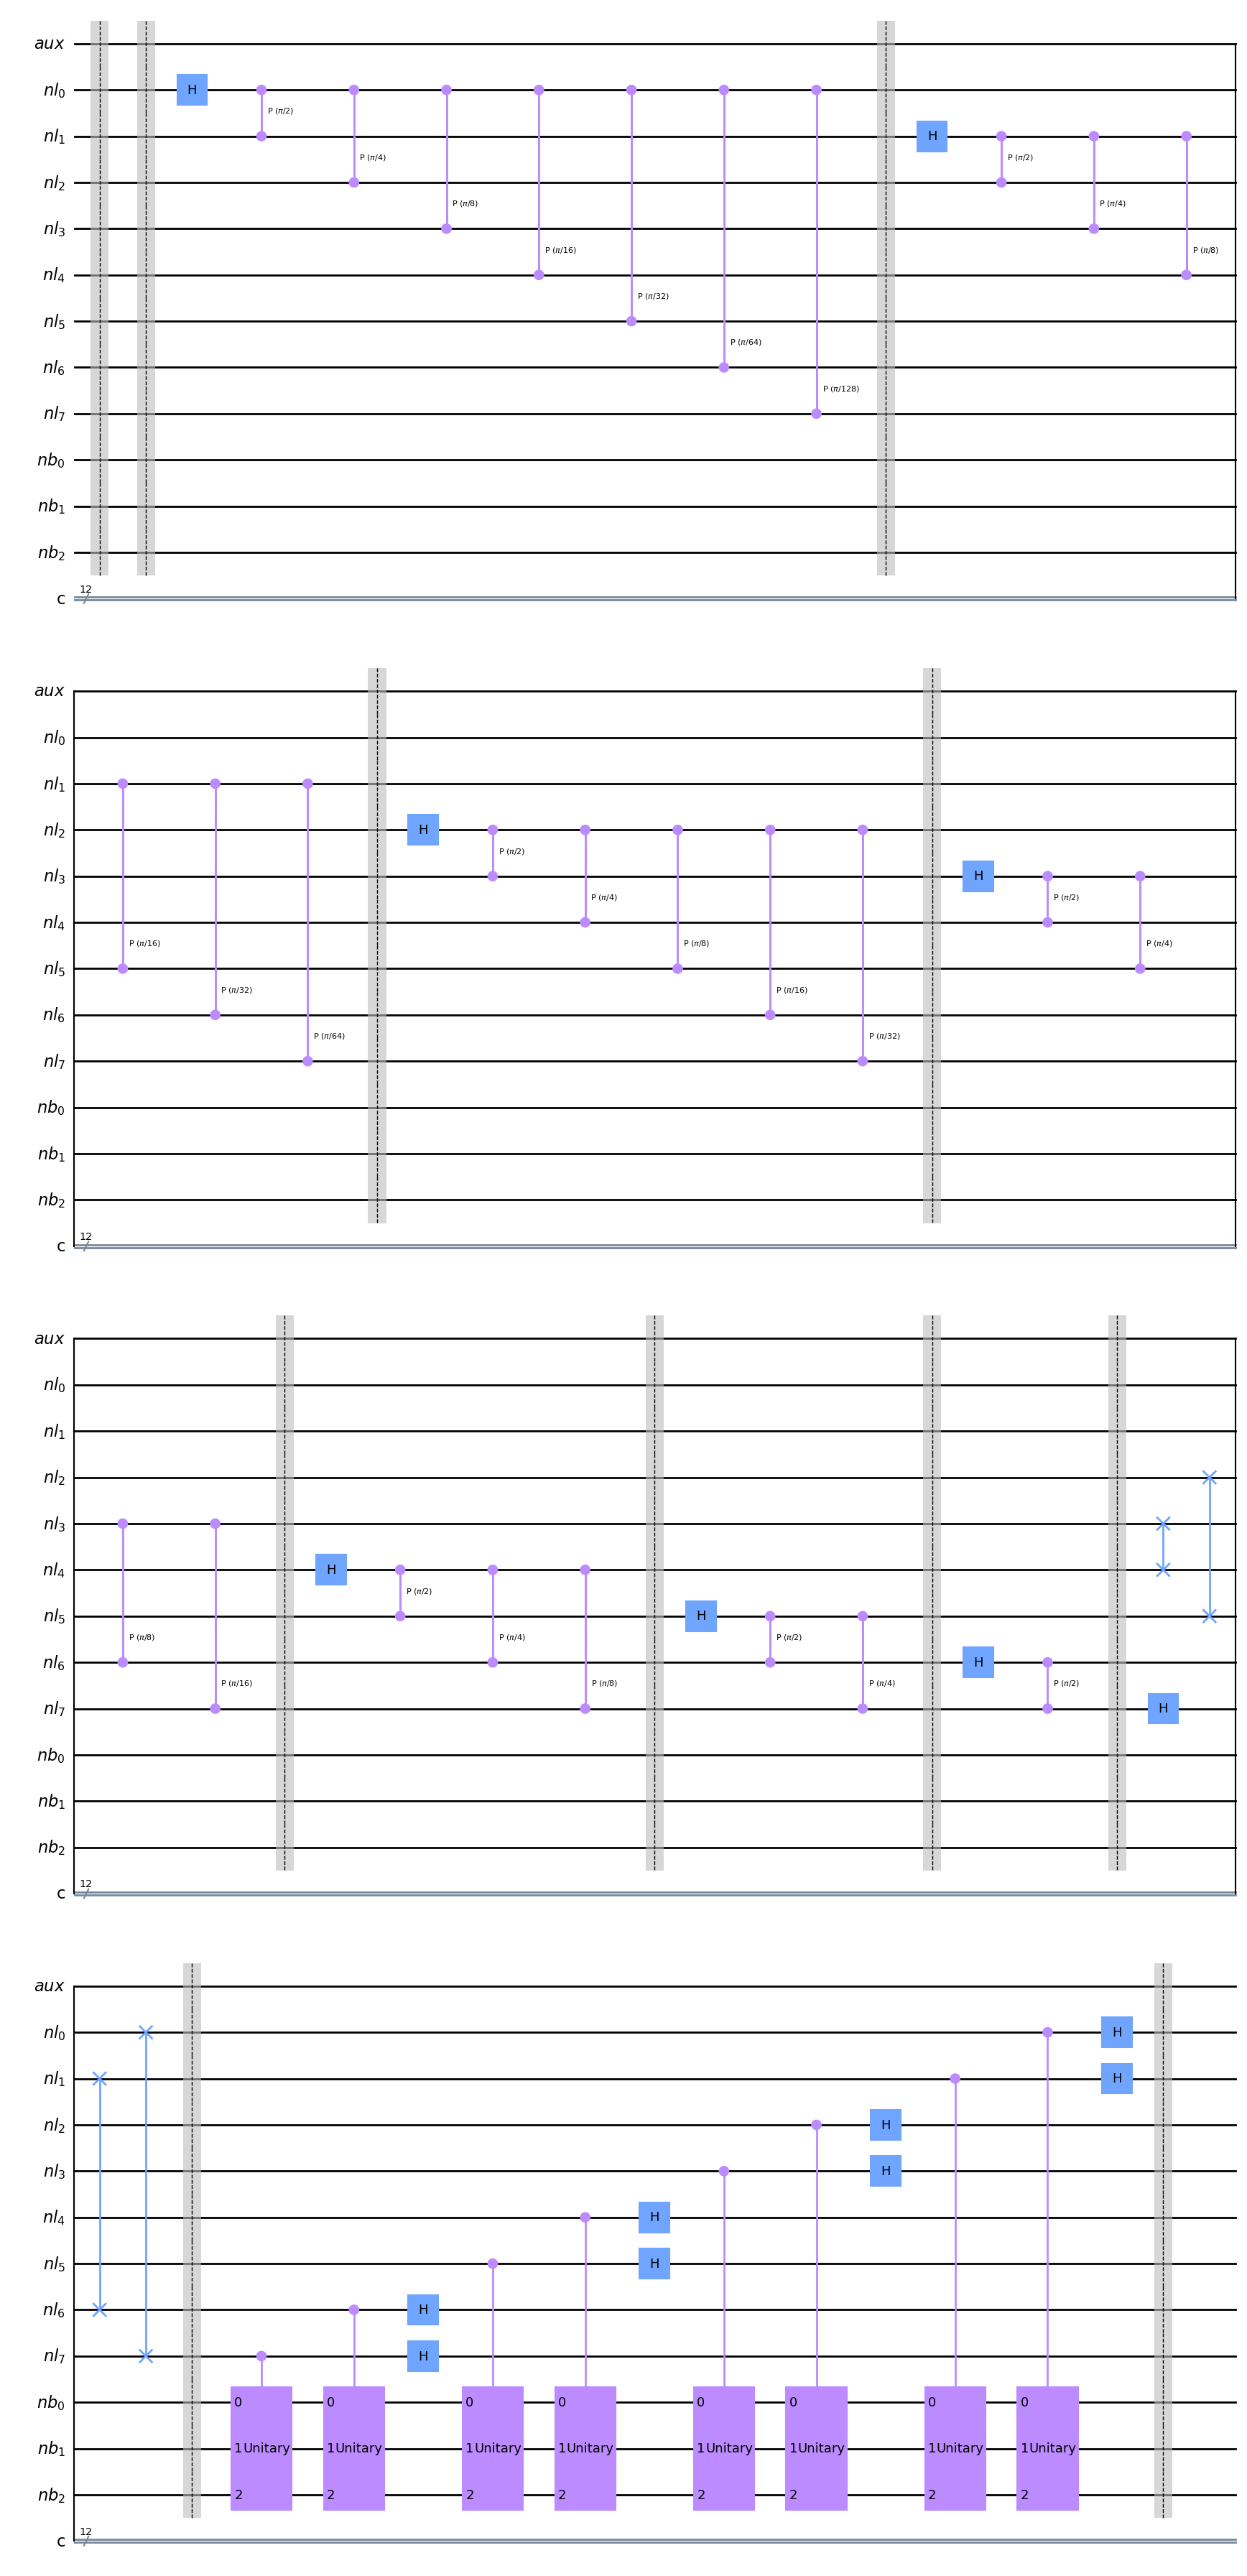

In [126]:
def construct_rev_qpe_circ():
    return qpe_circ.inverse()

rev_qpe_circ = construct_rev_qpe_circ()
rev_qpe_circ.draw('mpl')

### Putting it all together

We can summarize each of the circuit parts as the following.
- `init_circ` defines the loading of data $|b\rangle$ into the $n_b$ qubits.
- `qpe_circ` defines the circuit for quantum phase estimation, encoding the eigenvalues of $A'$ into the $n_l$ qubits. 
- `eig_invert_circ` defines the eigenvalue inversion circuit.
- `reverse_qpe_circ` defines the reverse qpe circuit.


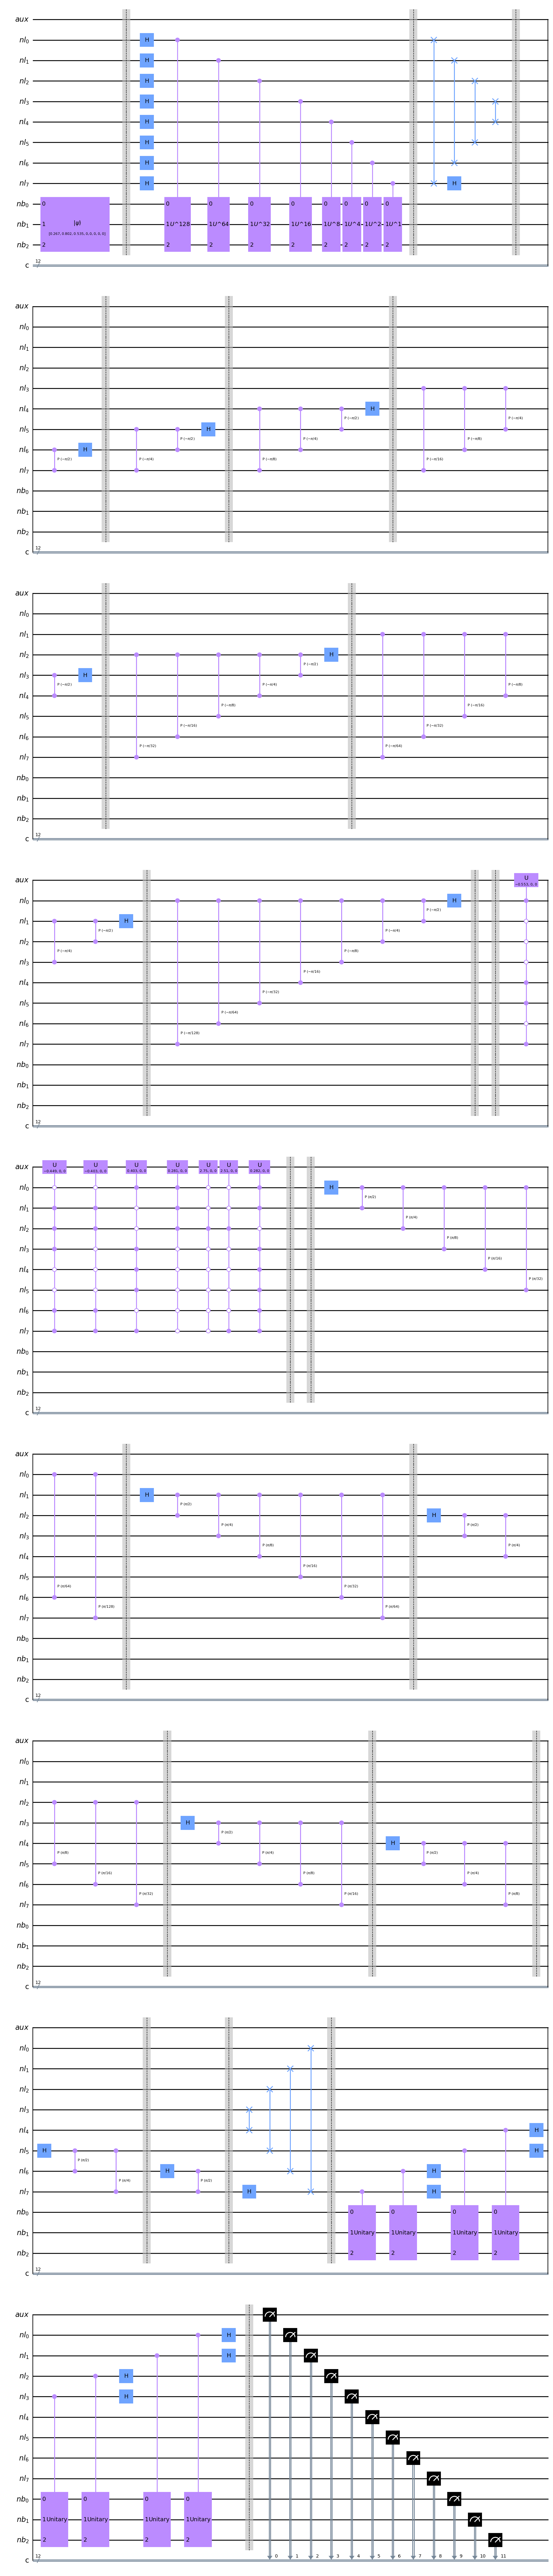

In [127]:
def construct_full_circuit(init_circ, qpe_circ, eig_invert_circ, reverse_qpe_circ):
    final_circ = init_circ.compose(qpe_circ).compose(eig_invert_circ).compose(reverse_qpe_circ) 
    final_circ.measure(aux, c[0]) # measure the aux qubit
    final_circ.measure(n_l, c[1:n_eig+1]) # measure n_l into the  3 classical registers
    final_circ.measure(n_b, c[n_eig+1:]) # measure to the next 3 classical registers

    return final_circ

full_circuit = construct_full_circuit(init_circ, qpe_circ, eig_invert_circ, rev_qpe_circ)
full_circuit.draw('mpl')

We need to repeatedly measure this circuit until we see the auxiliary qubit in the 1 state. After experimentation, as seen in the following cell, this should occur every 3/4th of the time. 

Let's measure both the auxiliary qubit and the $n_l$ qubits to measure for failures.

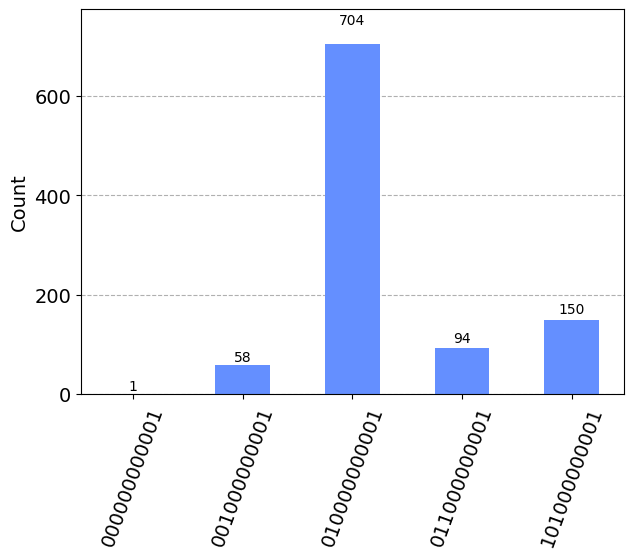

In [128]:
def checkFailed(class_regs):
    # input 10 classical registers, check if the outputs faield
    return  class_regs[-1] == '0' or any([i != '0' for i in class_regs[3:-1]])


def measure_all(full_circuit, nShots=10000):
    backend_qasm = Aer.get_backend('qasm_simulator')
    # perform constant_full_circuit just 1 time and plot the histogram of states! 
    
    res = execute(full_circuit, backend_qasm, shots=nShots).result() 

    final_counts = res.get_counts()
    
    # remove the failures
    numFailed = sum([val for key, val in final_counts.items() if checkFailed(key)])

    delItem = []
    for key, val in final_counts.items():
        if checkFailed(key):
            delItem.append(key)
            
    for item in delItem:
        final_counts.pop(item)

    return final_counts, numFailed

nShots = 10000
final_counts, numFailed = measure_all(full_circuit, nShots)
plot_histogram(final_counts)


However, a lot of these measurements failed, so delete the measurements where the auxiliary qubit is measured to be in the 0 state (conditional rotation failed). And where the n_l registers aren't in the $|0\rangle$ state (inverse QPE failed).

In [129]:
def get_x_hhl(nShots, numFailed):
    x_hhl = [i[1]/(nShots - numFailed) for i in sorted(final_counts.items(), key=lambda i: i[0], reverse=False)]
    x_hhl = [0, 0, 0] + x_hhl + [0, 0]
    return x_hhl

x_hhl = get_x_hhl(nShots, numFailed)
x_hhl

[0,
 0,
 0,
 0.0009930486593843098,
 0.05759682224428997,
 0.6991062562065541,
 0.09334657398212512,
 0.14895729890764647,
 0,
 0]

In [130]:

def get_x_actual(A_p, b_p):

    x_actual = scipy.linalg.solve(A_p, b_p)

    x_norm = (x_actual/scipy.linalg.norm(x_actual))**2

    return [round(i, 3) for i in (x_norm)]

x_actual = get_x_actual(A_p, b_p)

x_actual

[0.0, 0.0, 0.0, 0.238, 0.618, 0.144, 0.0, 0.0]

# Use the following cells for testing it out!

Inputs and Constants:

In [131]:
# --- inputs ---
A = np.matrix([[1, 1, 0], [-1, 1, -1], [0, .13, 1.3]]) # gets 1.9 and 3 distinct evals
b = np.array([1, 3, 2])
# --- constants ---
T = 150 # Used in hamiltonian evolution. Needs to be relatively large so that alpha in Eq (3) approximates as sync functions
n_eig = 8 # Used in QPE, number of qubits to estimate the eigenvalues of A, defines the precision of the eigenvalues up to n_eig bits
n = 3 # 2**n x 2**n A. This defines the number of qubits needed for the dimensions of this problem. Specifically 8 dimensions can be encoded with 3 qubits. 


 HHL Algo

In [132]:

# ------- HHL ALGO -------
# hermitian and pad the matrix
A_p = hermitian_and_pad_matrix(A)
b_p = pad_b(b)

# - step 1: load the data:
aux, n_l, n_b, c = construct_registers(n_eig, n, b_p) # construct registers
init_circ = construct_init_circ(n_eig, n, b_p)
# - step 2: QPE
U = convert_Ap_to_gate(A_p, T) # convert A_p to unitary gate
qpe_circ = construct_qpe_circ(U)
measure_circ = construct_qpe_measure_circ(init_circ, qpe_circ) # add measurements

counts = evaluate_QPE(measure_circ)

# manual inspection of the eigenvalues from QPE is necessary (in this case) to construct
# the conditional rotation
top_ev_bin = get_top_ev_bin(counts)
top_dec = get_top_ev_dec(top_ev_bin) # these are the decimal representations deciphered from the counts of the QPE evals
real_ev = get_real_ev(A_p) # these are the actual eigenvalues of A'
real_ev_dec = get_real_ev_dec(real_ev) # save the decimal representation to allow comparison to experimental ev's (lamdba's)

# !!! manually construct the correspondance array before moving on !!!
print_real_vs_exp_evals(top_dec, real_ev_dec, real_ev)

---------------compare this ev_dec array---------------
[115, 141, 99, 157, 32, 224, 33, 223, 142, 114]
---------------to the following real_ev's---------------
32 : -1.0
99 : -0.738
141 : -0.521
223 : 1.0
114 : 0.521
156 : 0.738
108 : 0.52
108 : 0.52
Use this to manually construct the `correspondance` array:
correspondance = [x_i] where x_i is 1 if the corresponding realev to the i'th experimental ev_dec is pos, else -1


In [133]:
# plot_histogram(counts, figsize=((20, 7))) # uncomment to see the histogram
correspondance = [-1, -1, -1, 1, 1, 1, 1, 1] # manually construct this array

In [134]:
# previous was [77, 179, 180, 76, 66, 190, 22, 234, 235, 21]
correspondance = [-1, 1, 1, -1, 1, -1, 1, -1, 1, -1]

After manually constructing the `correspondance` array. Continue building the circuit.

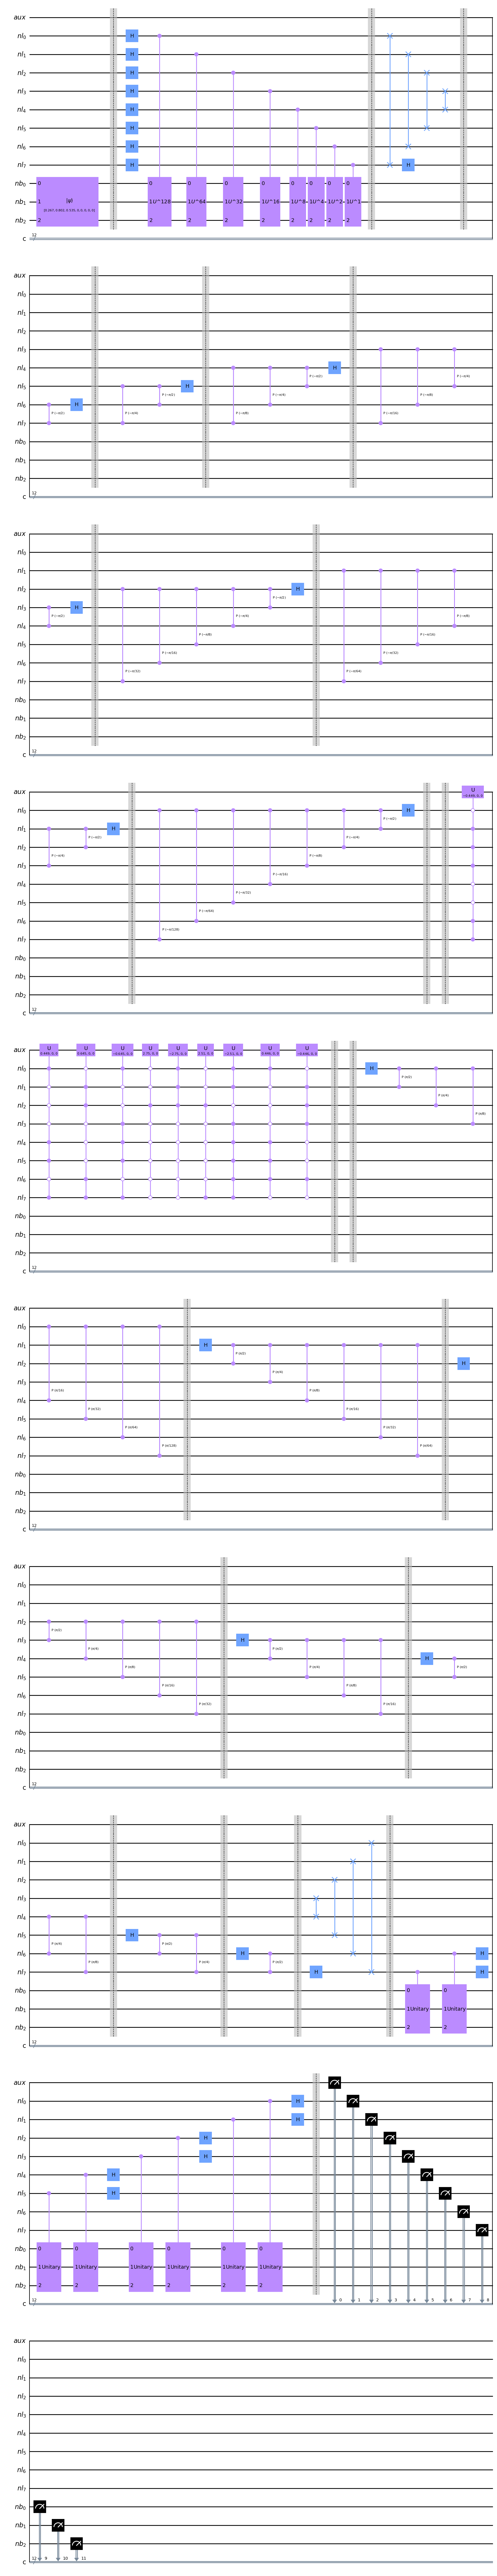

In [135]:

# Step 3: conditional rotation 

# compute C to be barely less than the minimum experimental eigenvalues
eig_invert_circ = construct_eig_invert_circ(correspondance, top_ev_bin)

# step 4: inverse QPE
rev_qpe_circ = construct_rev_qpe_circ()

# step 5: measure the auxiliary qubit to check for failures
full_circuit = construct_full_circuit(init_circ, qpe_circ, eig_invert_circ, rev_qpe_circ)

full_circuit.draw('mpl') # uncomment to see the full circuit design

Results!

In [136]:
nShots = 10000
final_counts, numFailed = measure_all(full_circuit, nShots)

plot_histogram(final_counts)

x_hhl = get_x_hhl(nShots, numFailed)
x_actual = get_x_actual(A_p, b_p)

print(f"Percentage of Failed Measurements: {numFailed/nShots*100}% Failed")
print(f"|x> from HHL: {x_hhl}")
print(f"|x> from actual: {x_actual}")


Percentage of Failed Measurements: 85.13% Failed
|x> from HHL: [0, 0, 0, 0.22125084061869535, 0.632817753866846, 0.14593140551445863, 0, 0]
|x> from actual: [0.0, 0.0, 0.0, 0.238, 0.618, 0.144, 0.0, 0.0]


In [137]:
print(f"Normalized difference: {scipy.linalg.norm(np.array(x_hhl) - np.array(x_actual))}")

Normalized difference: 0.022446168869097838


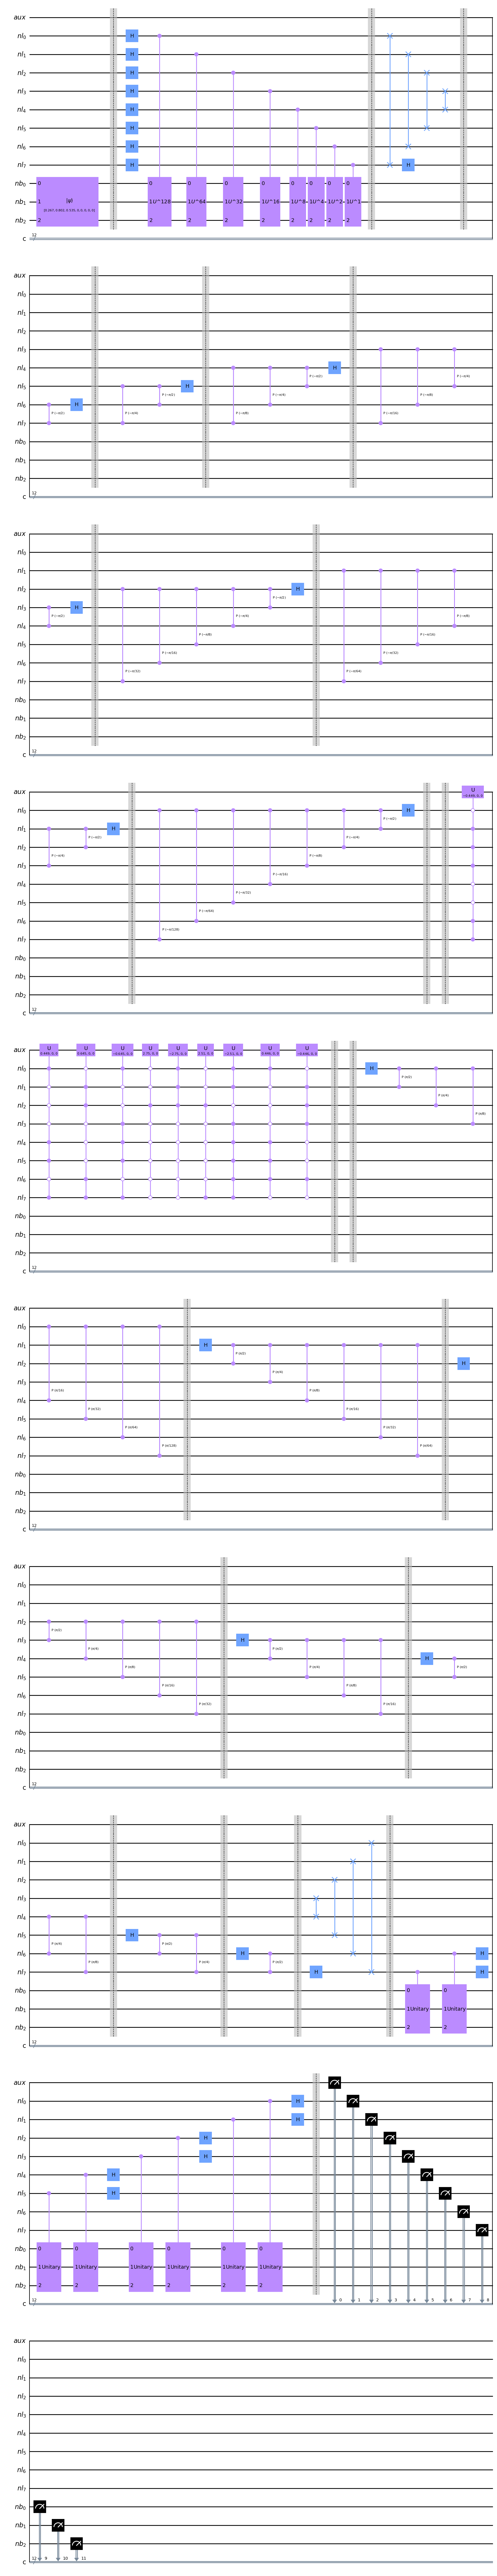

In [138]:
full_circuit.draw('mpl')